# Handwritten Digits Recognition Example with SVM using Intel DAAL

This lab is based on a [scikit-learn tutorial](http://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html) on the same subject.

In [1]:
%matplotlib inline 

In [2]:
# Intel DAAL related imports
from daal.data_management import HomogenNumericTable
from daal.algorithms.kernel_function import linear, rbf

# Import DAAL implementation of multi-class classifier based on SVM 
from svm_multi_class import * # See svm_multi_class.py

# Import quality metrics calculation module  
from quality_metrics import * # see quality_metrics.py
# Helpers 
from utils import *

# Import numpy, sklearn, matplotlib, seaborn
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting configurations
plt.rcParams['figure.figsize'] = (12, 8)
%config InlineBackend.figure_format = 'retina'
sns.set()

## Load dataset

Scikit-learn is bundled with some toy datasets. These datasets are available through [sklearn.datasets](http://scikit-learn.org/stable/datasets). The [load_digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits) method loads and returns the digits dataset. Because the dataset internally uses NumPy ndarray to store information, we can convert it to Intel DAAL numeric tables, and pass them to Intel DAAL algorithms. 

After loading the data, we take a quick look at the sizes and dimensions. There are 1797 samples (i.e. images of handwritten digits) in the dataset, and each sample has 64 features. Note that the images are stored in `digits.data` and the corresponding labels are stored in `digits.target`.

In [3]:
digits = load_digits()
print(digits.data.shape)
print(digits.target.shape)

(1797, 64)
(1797,)


## Visualize dataset
We can visualize the first 10 images. The code below is directly copied from the scikit-learn tutorial:

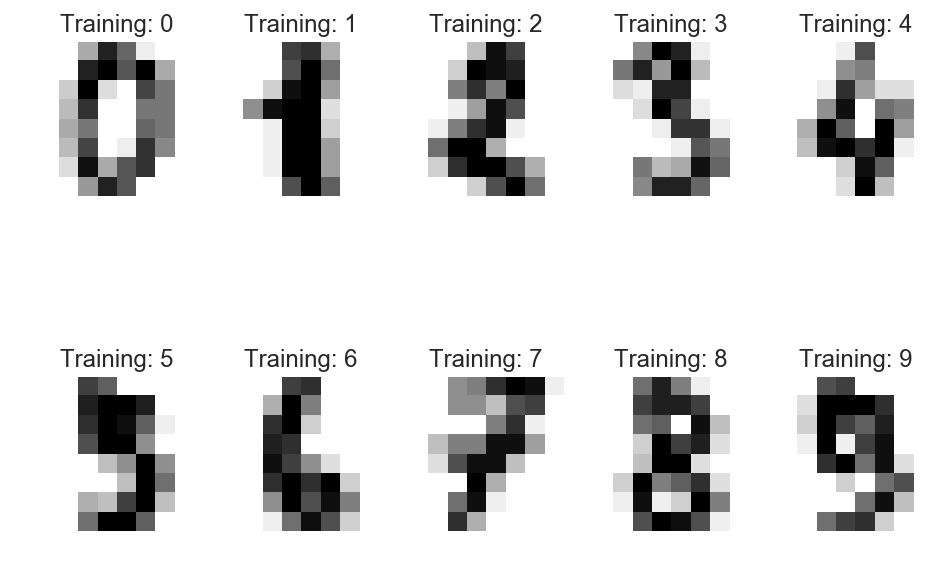

In [4]:
images_and_labels = list(zip(digits.images[:10], digits.target[:10]))
for index, (image, label) in enumerate(images_and_labels):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

## Data preparation
We save the last 20 samples from the dataset for testing, and use the rest to train a model.

As described above, images and the corresponding labels are accessible in `digits.data` and `digits.target`, respectively. The code below creates four Intel DAAL numeric tables, for `training_data`, `training_labels`, `test_data`, and `test_labels`.

In [5]:
# Split the data into training data and labels, and create numeric tables
nsamples = len(digits.images)
training_data = HomogenNumericTable(digits.data[:-20, :].astype(dtype=np.double))
training_labels = HomogenNumericTable(digits.target[:-20, np.newaxis].astype(dtype=np.double))

# Split the data into testing data and labels, and create numeric tables
test_data = HomogenNumericTable(digits.data[-20:, :].astype(dtype=np.double))
test_labels = HomogenNumericTable(digits.target[-20:, np.newaxis].astype(dtype=np.double))

## Create a multi-class classifier based on SVM

The definition of `MulticlassSVM` is in file [svm_multi_class.py](svm_multi_class.py). 
There are 10 digits, 0 to 9. So the number of classes is 10.

In [6]:
nclasses = 10
classifier = MulticlassSVM(nclasses)

Set parameters for SVM training and prediction algorithms

In [7]:
classifier.setSVMParams(
        cachesize = 32000000,
        kernel = linear.Batch_Float64DefaultDense(),
        shrinking = True)

## Train a model

In [8]:
%time svm_model = classifier.train(training_data, training_labels)

Wall time: 28 ms


## Test the model
Test the model using the other half of the data. Then, we check the performance of the model by computing quality metrics, and print the average accuracy. There are many aspects in a multi-class classifier's quality metrics. But "average accuracy" is probably the most commonly used inidcator. For other metrics that we can query, see definition of `QualityMetrics` in file [quality_metrics.py](quality_metrics.py).

In [9]:
%time predictions = classifier.predict(svm_model, test_data)

quality = QualityMetrics(test_labels, predictions, nclasses)
print('Average accuracy: {:.2f}%'.format(
    quality.getMulticlassAverageAccuracy()*100))

Wall time: 2 ms
Average accuracy: 100.00%


## Visualize predictions

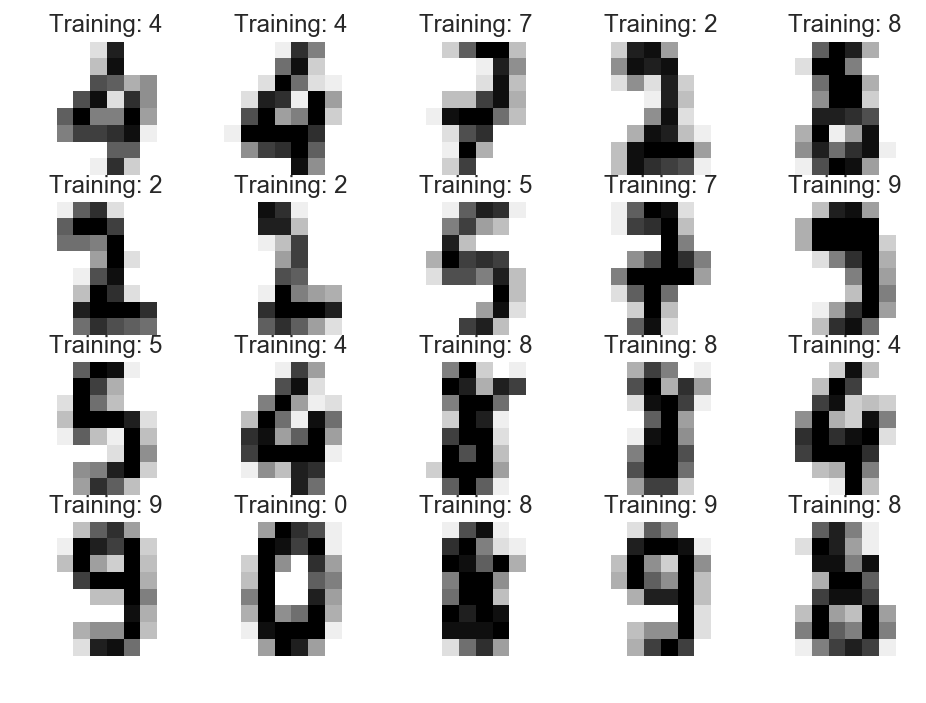

In [10]:
images_and_labels = list(zip(digits.images[-20:], getArrayFromNT(predictions)))
for index, (image, label) in enumerate(images_and_labels):
    plt.subplot(4, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

## Compare with scikit-learn SVC
As a comparison, below is a solution that uses Support Vector Classifier from scikit-learn [`sklearn.svm.svc`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

In [11]:
from sklearn import svm, metrics

In [15]:
sklearn_classifier = svm.SVC(kernel='linear')
%time sklearn_classifier.fit(digits.data[:-20, :], digits.target[:-20])

Wall time: 75 ms


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [16]:
%time sklearn_predictions = sklearn_classifier.predict(digits.data[-20:, :])

Wall time: 2 ms


In [17]:
sklearn_quality = metrics.accuracy_score(digits.target[-20:, np.newaxis], sklearn_predictions)
print('Average accuracy: {:.2f}%'.format(sklearn_quality*100))

Average accuracy: 100.00%
